In [1]:
! nvidia-smi

Wed Jun  3 08:14:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101
     |████████████████████████████████| 163kB 3.5MB/s 


### Unzip FG_BG, Mask, Depth and corresponding BG images from gdrive

In [4]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.57509 minutes


### Copying Log file that contains FG_BG file names, their path in gdrive & corresponding BG file name from which they were made 

In [5]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


### Copying SRC libraries from Github to Colab.

In [6]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 459 (delta 10), reused 0 (delta 0), pack-reused 441
Receiving objects: 100% (459/459), 14.90 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [7]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src/losses'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src/losses
Test1.py  Test2.py  Test.py  Train1.py	Train2.py  Train.py


### Importing modules from Colab data folder to Colab session 

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.dataset import make1data as md1
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.losses  import Train1 as Train1
from src.losses  import Test1  as Test1
from src.losses  import Train2 as Train2
from src.losses  import Test2  as Test2
from src.utils   import Freeze_Layers as Freeze

### Creating a list - content_list for FG_BG log file. This content_list will be used to create dataloader to pick-up input images randomly for both training and testing

In [9]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs_small  = 96
bs_medium = 96
bs_large  = 16
bs_test   = 96
bs_display= 8
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating tranforms. For test data, GT mask & GT depth only 'To Tensor' & 'Resize' is used.

In [0]:
import albumentations as A
lst = [(64,64),(96,96),(192,192)]
fg_bg_mean, fg_bg_stdev                    = [0.56670278, 0.49779153, 0.43632878], [0.25049532, 0.2468085, 0.25520498]
mask_mean,  mask_stdev                     = [0.20249742], [0.39961225]
depth_mean, depth_stdev                    = [0.32939295], [0.24930712]
bg_mean, bg_stdev                          = [0.58245822, 0.51269352, 0.43691653], [0.24252189, 0.24318804, 0.25401604]
#fg_bg_mean, fg_bg_stdev                    = [144.5, 126.9, 111.26], [63.88, 62.94, 65.08]
#mask_mean,  mask_stdev                     = [51.6], [101.9]
#depth_mean, depth_stdev                    = [83.995], [63.57]
#bg_mean, bg_stdev                          = [148.53, 130.74, 111.41], [61.84, 62.01, 64.77]
fg_bg_transforms, bg_transforms, mask_transforms, depth_transforms = {}, {}, {}, {}
test_fg_bg_transforms, test_bg_transforms                          = {}, {}
for i in range(len(lst)):
    ht, wd = lst[i]
    cut_out_size = int(ht/4)
    fg_bg_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),
                                                                     A.Cutout(num_holes=1,max_h_size=cut_out_size,max_w_size=cut_out_size),])
    bg_transforms["t_{0}".format(i)]    = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.IAAAdditiveGaussianNoise(),
                                                                     A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                     A.Normalize(mean=bg_mean, std=bg_stdev),])
    mask_transforms["t_{0}".format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=mask_mean, std=mask_stdev),])
    depth_transforms["t_{0}".format(i)] = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                     A.Normalize(mean=depth_mean, std=depth_stdev),])
    test_fg_bg_transforms["t_{0}" .format(i)]  = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=fg_bg_mean, std=fg_bg_stdev),])
    test_bg_transforms["t_{0}" .format(i)]        = Alb.Albumentations_transform([A.Resize(ht,wd,always_apply=True,p=1),
                                                                              A.Normalize(mean=bg_mean, std=bg_stdev),])

In [12]:
print(fg_bg_transforms)
print(bg_transforms)
print(mask_transforms)
print(depth_transforms)
print(test_fg_bg_transforms)
print(test_bg_transforms)

{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f3780b8>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f3789b0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f3772e8>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f378278>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f378b70>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f3774a8>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f3783c8>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f378cc0>, 't_2': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f3775f8>}
{'t_0': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0x7f1b7f378518>, 't_1': <src.dataset.Alb_data_transforms.Albumentations_transform object at 0

### Creating dataloader using content_list. Since total 280K images are present in training set, 5 cohorts are created to manage the training volume.
- 0 - 80k    -> size 64x64    
- 80k - 160k -> size 64x64    
- 160k -220k -> size 64x64    
- 220k -260k -> size 96x96    
- 260k -280k -> size 192x192  
- 280k -400k -> size 64x64 -> Test dataset

In [0]:
train_ds_mini_1    = md1.Make1data(f1, content_list, 0, 1000,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_2    = md1.Make1data(f1, content_list, 1000, 2000,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_mini_3    = md1.Make1data(f1, content_list, t160k, t220k,  
                             fg_bg_transforms['t_0'],bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
train_ds_medium    = md1.Make1data(f1, content_list, t220k, t260k,  
                             fg_bg_transforms['t_1'],bg_transforms['t_1'],mask_transforms['t_1'],depth_transforms['t_1'])
train_ds_large   = md1.Make1data(f1, content_list, t260k, t280k,  
                             fg_bg_transforms['t_2'],bg_transforms['t_2'],mask_transforms['t_2'],depth_transforms['t_2'])
test_ds          = md1.Make1data(f1, content_list, t280k, t400k,  
                             test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])

In [0]:
train_dl_mini_1  = DataLoader(train_ds_mini_1, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_2  = DataLoader(train_ds_mini_2, batch_size = bs_small,shuffle = True, pin_memory = True)
train_dl_mini_3  = DataLoader(train_ds_mini_3, batch_size = bs_small,  shuffle = True, pin_memory = True)
train_dl_medium  = DataLoader(train_ds_medium, batch_size = bs_medium, shuffle = True, pin_memory = True)
train_dl_large   = DataLoader(train_ds_large,  batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl          = DataLoader(test_ds,         batch_size = bs_test,  shuffle = True, pin_memory = True)

In [0]:
test_ds_display = md1.Make1data(f1, content_list, 399000, 400000,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = bs_display,  shuffle = True, pin_memory = True)

### To check if batch & sizes are coming correctly & whether dataloader and transforms are working as expected

In [0]:
images_mini_1 = next(iter(train_dl_mini_1))
images_mini_2 = next(iter(train_dl_mini_2))
images_mini_3 = next(iter(train_dl_mini_3))
images_medium = next(iter(train_dl_medium))
images_large  = next(iter(train_dl_large))
images_test   = next(iter(test_dl))

In [17]:
print('B1:',[(k, v.shape) for k, v in images_mini_1.items()])
print('B2:',[(k, v.shape) for k, v in images_mini_2.items()])
print('B3:',[(k, v.shape) for k, v in images_mini_3.items()])
print('B4:',[(k, v.shape) for k, v in images_medium.items()])
print('B5:',[(k, v.shape) for k, v in images_large.items()])
print('B6:',[(k, v.shape) for k, v in images_test.items()])

B1: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B2: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B3: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B4: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
B5: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
B6: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


### To display images created out of dataloader & transform to ensure images are coming out for display correctly

In [0]:
imgs = images_mini_1['f3']

In [0]:
def show(tensors, mean, stdev, figsize= (10,10), *args, **kwargs):

  tensor_mean   = mean
  tensor_stdev  = stdev
  for i in range(tensors.shape[0]):
      if tensors.shape[1] ==3:
        for j in range(0,3):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])
      if tensors.shape[1] ==1:
        for j in range(0,1):  
          tensors[i,j] = ((tensors[i,j] * tensor_stdev[j]) + tensor_mean[j])

  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

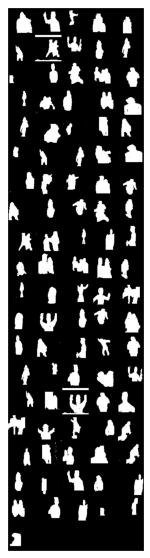

In [20]:
show(imgs, mask_mean, mask_stdev, nrow=rows)

### Initializing the model and assigning it to Cuda

In [21]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

### Defining Freeze class. We are using transfer learning & hence this class will be used to freeze the layers as required.

In [0]:
freezer = Freeze.Freezer()

In [0]:
for name, module in model.named_modules():
    print('name:',name)

### Defining Loss Criterion & creating scheduler

In [0]:
criterion1  = nn.BCEWithLogitsLoss()
#criterion1  = DiceLoss()
kernel_size = 3
#criterion1  = SSIM(kernel_size, reduction = 'mean')
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

### Defining train & test loss classes

In [0]:
train_loss_fn = Train2.Training_loss1()
test_loss_fn  = Test2.Testing_loss1()

### Reloading model from last saved weights that are present in gdrive

In [25]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0531V19A.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
path_name       = '/content/gdrive/My Drive/plots_0602_V20C/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0602V20C.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

### Train & Test the model

In [27]:
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,3):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs_small, train_dl_mini_1
     #freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs_small, train_dl_mini_2
     #freezer.freeze_depth_layers(model)   
  elif epoch < 4:
     batch_size, loader = bs_small,  train_dl_mini_1
     freezer.freeze_depth_layers(model)
  elif epoch < 5:
     batch_size, loader  = bs_small, train_dl_mini_2
     freezer.freeze_depth_layers(model)   

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs_display, test_dl_display
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

TR1|0|-2.390|0.431|0.644|0.598:   0%|          | 0/11 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/1000 (0%)]	Loss:-4.35001 Mask_Loss:-2.39042 Dpth_Loss:0.43084 Mask_IOU:0.64446 Dpth_IOU: 0.59787


TR1|0|-2.390|0.431|0.644|0.598:   9%|▉         | 1/11 [00:04<00:43,  4.34s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0602V20C.pt Epoch & Batch-ID: 1 0


TR1|9|-2230.622|0.450|0.138|0.223:  82%|████████▏ | 9/11 [00:15<00:02,  1.45s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 9 [864/1000 (82%)]	Loss:-4460.79297 Mask_Loss:-2230.62158 Dpth_Loss:0.45009 Mask_IOU:0.13787 Dpth_IOU: 0.22331


TR1|10|-11945.913|0.454|0.192|0.254: 100%|██████████| 11/11 [00:18<00:00,  1.68s/it]
TS1|0|666357.000|0.475|0.197|0.333:   0%|          | 0/125 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/1000 (0%)]	Test_Loss: 1332714.500000 Mask_Loss: 666357.00000 Dpth_Loss: 0.47491 Mask_IOU: 0.19735 Dpth_IOU: 0.33328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|124|835657.000|0.481|0.226|0.207:  99%|█████████▉| 124/125 [00:16<00:00,  8.45it/s] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [496/1000 (99%)]	Test_Loss: 1671314.500000 Mask_Loss: 835657.00000 Dpth_Loss: 0.48057 Mask_IOU: 0.22564 Dpth_IOU: 0.20670


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|124|835657.000|0.481|0.226|0.207: 100%|██████████| 125/125 [00:16<00:00,  7.49it/s]
TR2|0|-13949.312|0.450|0.093|0.236:   0%|          | 0/11 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/1000 (0%)]	Loss:-27898.17578 Mask_Loss:-13949.31250 Dpth_Loss:0.44954 Mask_IOU:0.09290 Dpth_IOU: 0.23606


TR2|0|-13949.312|0.450|0.093|0.236:   9%|▉         | 1/11 [00:03<00:36,  3.66s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0602V20C.pt Epoch & Batch-ID: 2 0


TR2|9|-27324.777|0.439|0.000|0.297:  82%|████████▏ | 9/11 [00:15<00:02,  1.41s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 9 [864/1000 (82%)]	Loss:-54649.11719 Mask_Loss:-27324.77734 Dpth_Loss:0.43940 Mask_IOU:0.00000 Dpth_IOU: 0.29719


TR2|10|-150760.312|0.439|0.000|0.290: 100%|██████████| 11/11 [00:17<00:00,  1.63s/it]
TS2|0|10029000.000|0.500|0.000|0.372:   0%|          | 0/125 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/1000 (0%)]	Test_Loss: 20058000.000000 Mask_Loss: 10029000.00000 Dpth_Loss: 0.49988 Mask_IOU: 0.00000 Dpth_IOU: 0.37225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|124|22652302.000|0.500|0.000|0.295:  98%|█████████▊| 123/125 [00:12<00:00, 10.32it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [496/1000 (99%)]	Test_Loss: 45304604.000000 Mask_Loss: 22652302.00000 Dpth_Loss: 0.49994 Mask_IOU: 0.00000 Dpth_IOU: 0.29532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|124|22652302.000|0.500|0.000|0.295: 100%|██████████| 125/125 [00:13<00:00,  9.44it/s]


In [0]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

In [0]:
 
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")

In [0]:
test_ds_display = md1.Make1data(f1, content_list, 390000, t400k,  
                  test_fg_bg_transforms['t_0'],test_bg_transforms['t_0'],mask_transforms['t_0'],depth_transforms['t_0'])
test_dl_display = DataLoader(test_ds_display, batch_size = 8,  shuffle = True, pin_memory = True)
batch_size, loader = 8, test_dl_display
epoch = 11
test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)